# Inverse Gardner

Nothing fancy here, just a small notebook that shows how to do a very simple thing, i.e. fitting velocity-density data with the inverse form of Gardner's law (useful to derive velocity when you only have density available).

This notebook also shows how to use [SymPy](http://www.sympy.org/en/index.html) to check your equations, which may become handy if you're mathematically-impaired like me.

Gardner's law is:

$ \rho = d \cdot V^f $

Average parameters for sandstones and shales are (see also Simm & Bacon, Seismic Amplitude, 2014, pag.152.): 

$ d = 0.31 $ (when velocities are in m/s)

$ f = 0.25 $


The inverse form of the relation is then:

$ V = (\frac{\rho}{d})^{1/f} $

Let's check it out using SymPy:


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy
sympy.init_printing(use_latex='mathjax')

%matplotlib inline
# comment out the following if you're not on a Mac with HiDPI display
%config InlineBackend.figure_format = 'retina'

In [2]:
d, V, f, rho = sympy.symbols('d, V, f, rho')
gardner_expr=sympy.Eq(rho, d*V**f)

gardner_expr

     f  
ρ = V ⋅d

In [3]:
sympy.solve(gardner_expr,V)

⎡    ___⎤
⎢   ╱ ρ ⎥
⎢f ╱  ─ ⎥
⎣╲╱   d ⎦

In [4]:
print(sympy.solve(gardner_expr,V))

[(rho/d)**(1/f)]


## example using synthetic data

First I will create a vector of velocities, use direct Gardner's relation ($\rho = d \cdot V^f $) to derive density and add some random noise to the density to make it look more 'real'.

On this synthetic dataset I will then do an empirical fit using the inverse Gardner equation (assuming that velocities are missing, i.e. V is the unknown) then plot the model curve on top of it.

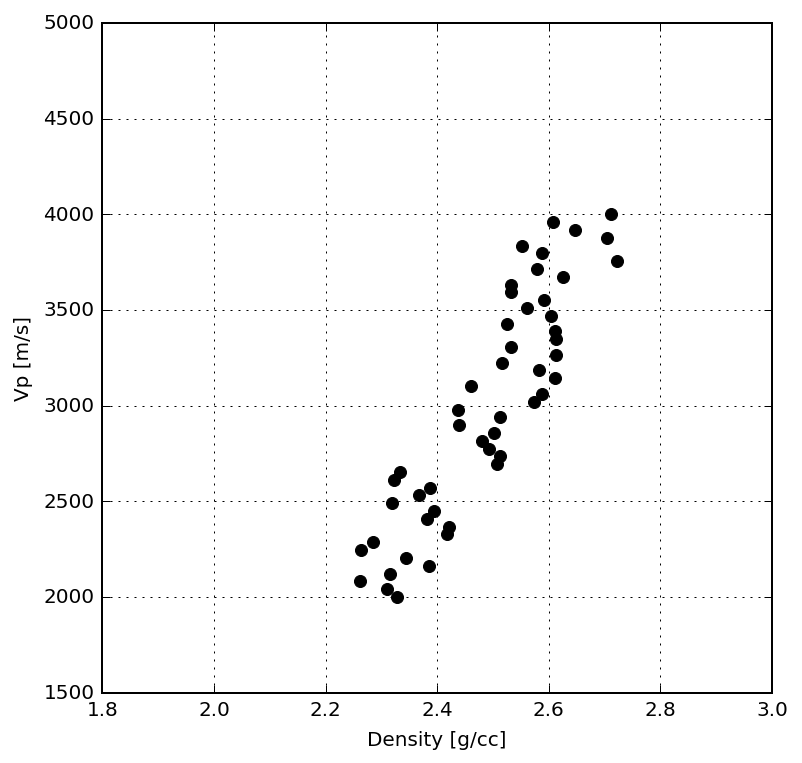

In [5]:
vp_test=np.linspace(2000, 4000)
rho_test=0.31*vp_test**0.25

noise=np.random.uniform(0.1,.3,vp_test.shape)
rho_test += noise

plt.figure(figsize=(6,6))
plt.plot(rho_test,vp_test,'ok')
plt.xlabel('Density [g/cc]'), plt.xlim(1.8,3)
plt.ylabel('Vp [m/s]'), plt.ylim(1500,5000)
plt.grid()

[ 0.26691885  0.27930576]


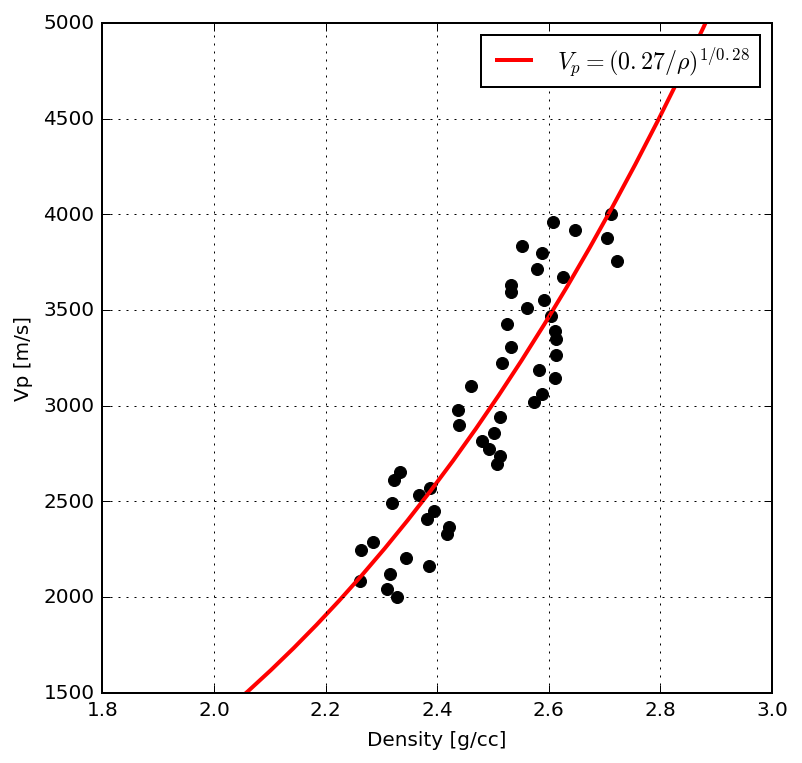

In [6]:
from scipy.optimize import curve_fit
def inv_gardner(rho, d, F):
    return (rho/d)**(1/F)

popt_synt, pcov = curve_fit(inv_gardner,rho_test,vp_test)
print(popt_synt)

rho_synt=np.linspace(1, 3, 50)
vp_synt=inv_gardner(rho_synt, *popt_synt)

plt.figure(figsize=(6,6))
plt.plot(rho_test,vp_test,'ok')
plt.plot(rho_synt, vp_synt, '-r', lw=2, label=r'$ V_p = (%.2f / \rho)^{1/%.2f}$' % (popt_synt[0],popt_synt[1]))
plt.xlabel('Density [g/cc]'), plt.xlim(1.8,3)
plt.ylabel('Vp [m/s]'), plt.ylim(1500,5000)
plt.grid()
plt.legend()

## Application to real case

First I will load some real well log data (for details on this well see also [my seismic petrophysics notebook](http://nbviewer.jupyter.org/github/aadm/geophysical_notes/blob/master/seismic_petrophysics.ipynb)).

In [7]:
ll=np.recfromcsv('qsiwell2_frm.csv')
z    =ll['depth']
gr   =ll['gr']
vpb  =ll['vp_frmb']
rhob =ll['rho_frmb']
nphi =ll['nphi']

Then I will plot the data, using the brine-replaced logs of density and velocity (it is always good practice to avoid unnecessary complications like mixing data containing different pore fluids):

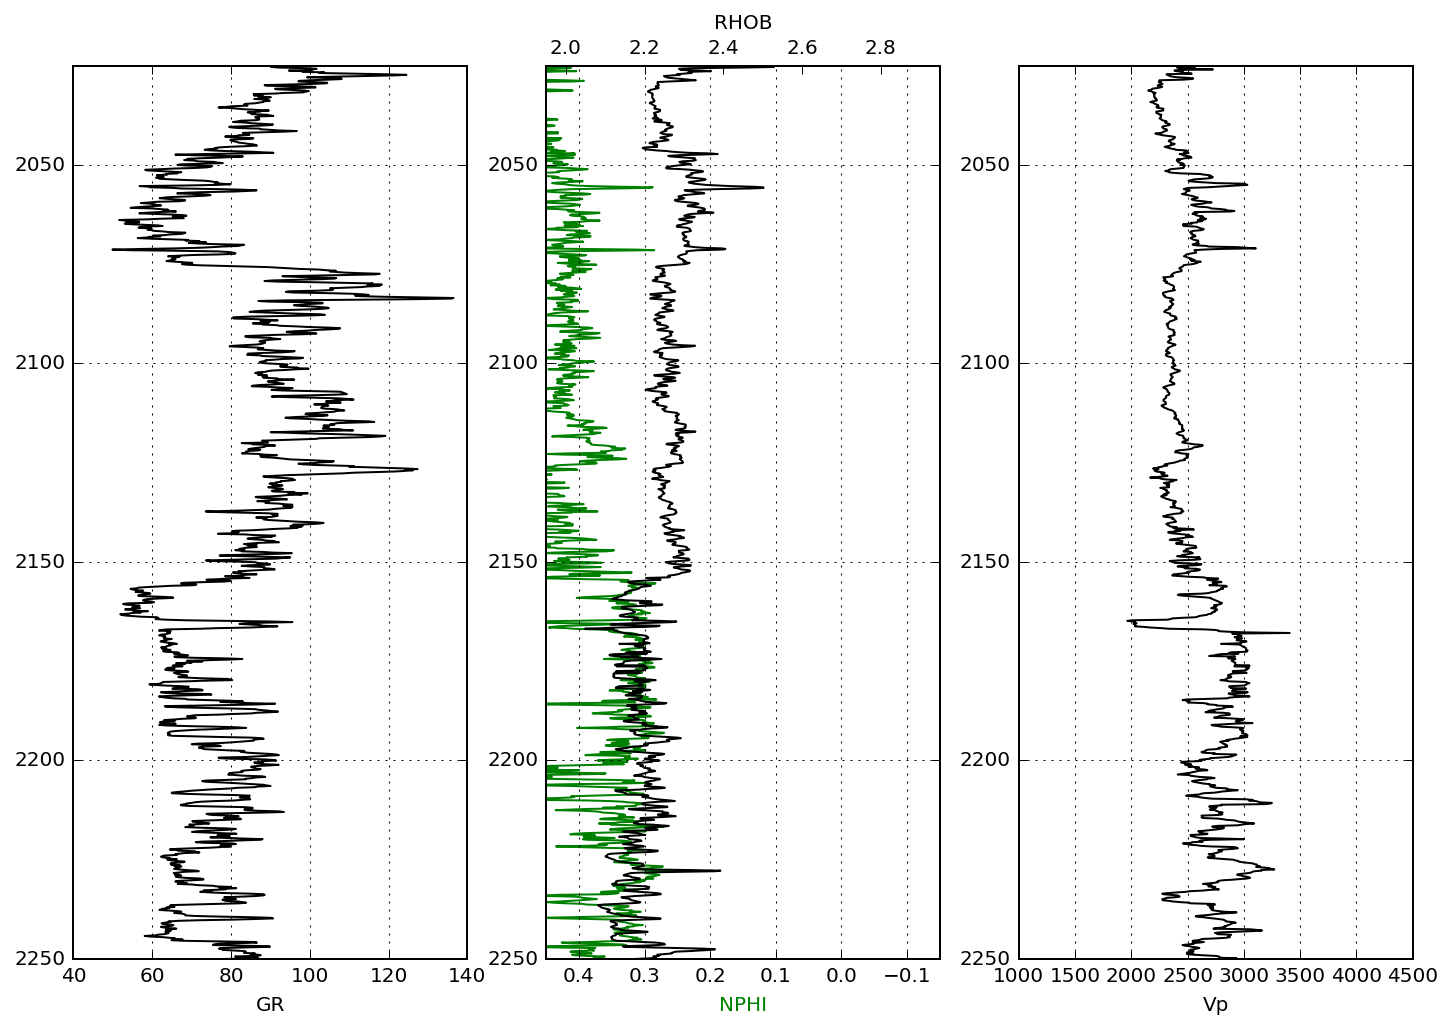

In [8]:
ztop=2025
zbot=2250

f,ax = plt.subplots(1,3,figsize=(12,8))
ax[0].plot(gr,z,'-k')
ax[0].set_xlabel('GR')
ax[1].plot(nphi,z,'-g')
ax[1].set_xlabel('NPHI',color='g'), ax[1].set_xlim(0.45,-0.15)
ax1bis = ax[1].twiny()
ax1bis.plot(rhob, z, 'k')
ax1bis.set_xlabel('RHOB', color='k'),  ax1bis.set_xlim(1.95,2.95)
ax[2].plot(vpb,z,'-k')
ax[2].set_xlabel('Vp')
for aa in ax:
    aa.set_ylim(zbot,ztop)
    aa.grid()

The following code simply puts "holes" (`np.nan`) in a small portion of the velocity log, then repeats the plot above to show where the missing data is:

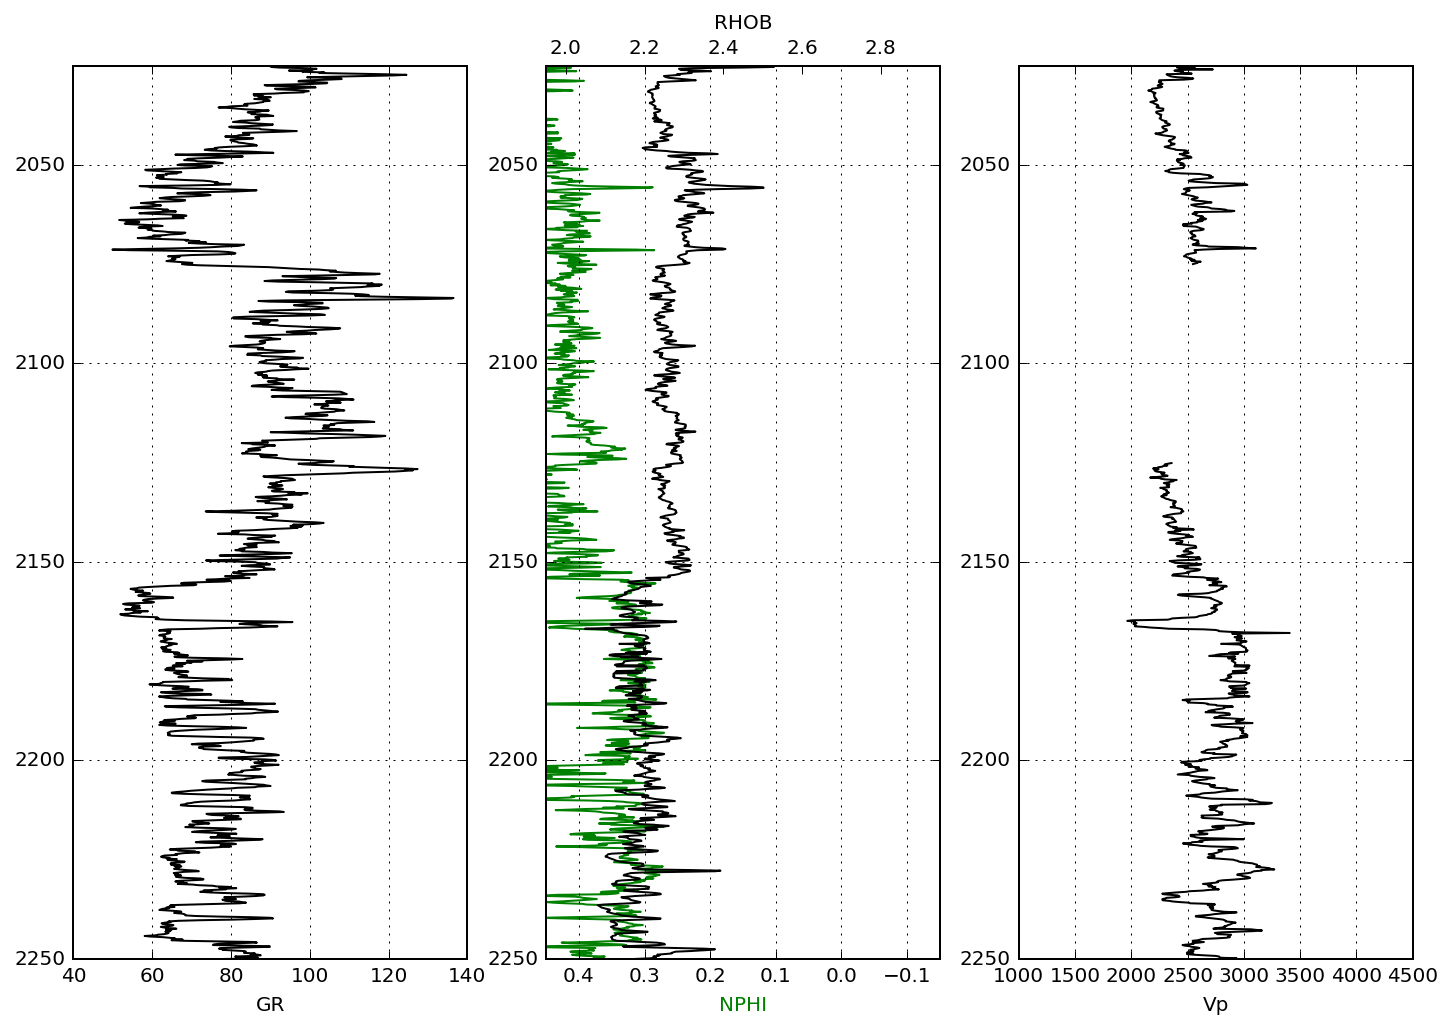

In [9]:
vp1=vpb.copy()
hole=(z>2075) & (z<2125)
vp1[hole]=np.nan

fig,ax = plt.subplots(1,3,figsize=(12,8))
ax[0].plot(gr,z,'-k')
ax[0].set_xlabel('GR')
ax[1].plot(nphi,z,'-g')
ax[1].set_xlabel('NPHI',color='g'), ax[1].set_xlim(0.45,-0.15)
ax1bis = ax[1].twiny()
ax1bis.plot(rhob, z, 'k')
ax1bis.set_xlabel('RHOB', color='k'),  ax1bis.set_xlim(1.95,2.95)
ax[2].plot(vp1,z,'-k')
ax[2].set_xlabel('Vp')
for aa in ax:
    aa.set_ylim(zbot,ztop)
    aa.grid()

Now let's crossplot velocity and density from the selected depth window (2025 to 2250 m) and further select the interval where we want to fit the inverse Gardner-type relation.

This is where arguably the interpreter's decision weights more than everything else. For example I have selected the interval above 2150 m because this is where I see a drastic change in the density paired to higher GR values, to mark the passage to a shale-dominated environment and the occurrence of a possible cap-rock.

However, not everything is shale in here! So that's why the additional cutoff on GR, to select only the datapoints with greater shale content (i.e., higher GR values).

In this way I have now cut out a portion of the velocity-density dataset that is mostly shales, possibly from a similar depositional environment; this subset is shown in the figure below on the right.

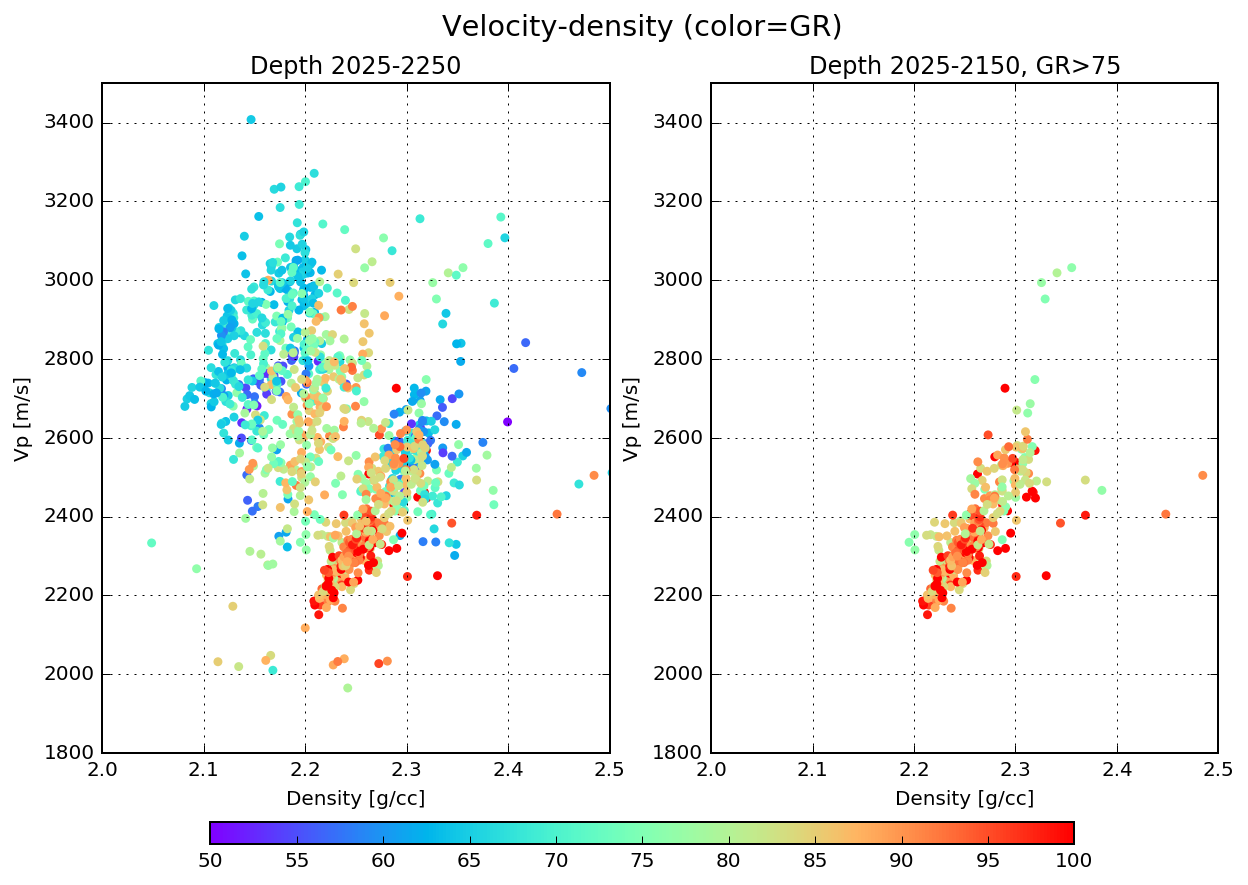

In [10]:
f1=(z>=ztop) & (z<=zbot) & (np.isfinite(vp1))
f2=(z>=ztop) & (z<=2150) & (np.isfinite(vp1))  & (gr>75)

fig,ax = plt.subplots(1,2,figsize=(10,6))
pl0=ax[0].scatter(rhob[f1],vpb[f1],20,c=gr[f1],cmap='rainbow',edgecolors='None',vmin=50,vmax=100)
pl1=ax[1].scatter(rhob[f2],vpb[f2],20,c=gr[f2],cmap='rainbow',edgecolors='None',vmin=50,vmax=100)
for aa in ax:
    aa.set_xlabel('Density [g/cc]'), aa.set_xlim(2.0,2.5)
    aa.set_ylabel('Vp [m/s]'), aa.set_ylim(1800,3500)
    aa.grid()
cax = fig.add_axes([0.2, 0.02, 0.6, 0.025])
fig.colorbar(pl0, cax=cax, orientation='horizontal')
plt.suptitle('Velocity-density (color=GR)', fontsize='x-large')
ax[0].set_title('Depth {}-{}'.format(ztop,zbot))
ax[1].set_title('Depth {}-{}, GR>{}'.format(ztop,2150,75))

Now I will fit the data with an inverse Gardner-type function and draw the same figure again, this time with the empirical fit curve drawn on top of the selected subset of points:

[ 0.05380012  0.48122711]


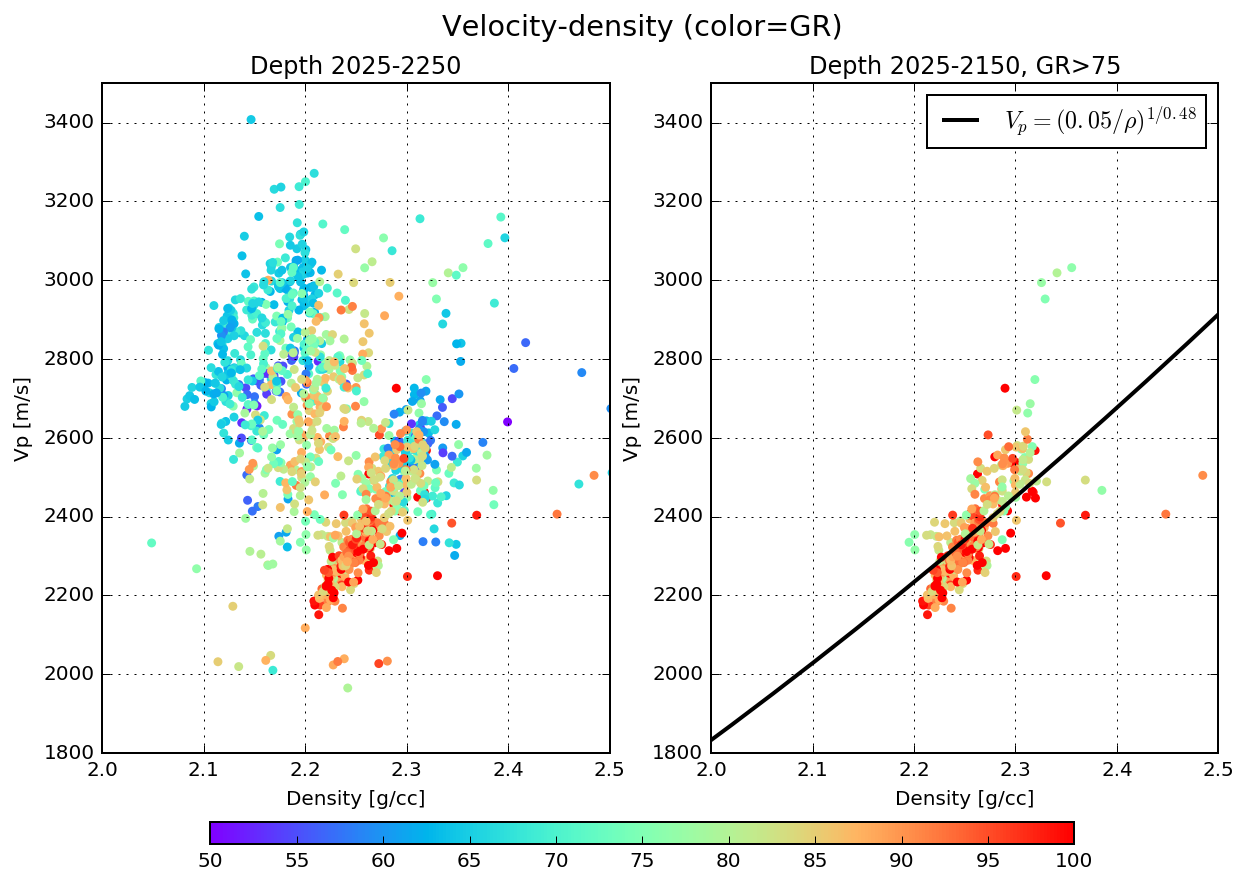

In [12]:
popt, pcov = curve_fit(inv_gardner, rhob[f2], vpb[f2])
print(popt)

rho_gardner=np.linspace(1, 3, 50)
vp_gardner=inv_gardner(rho_gardner, *popt)

fig,ax = plt.subplots(1,2,figsize=(10,6))
pl0=ax[0].scatter(rhob[f1],vpb[f1],20,c=gr[f1],cmap='rainbow',edgecolors='None',vmin=50,vmax=100)
pl1=ax[1].scatter(rhob[f2],vpb[f2],20,c=gr[f2],cmap='rainbow',edgecolors='None',vmin=50,vmax=100)
ax[1].plot(rho_gardner, vp_gardner, '-k', lw=2, label=r'$ V_p = (%.2f / \rho)^{1/%.2f}$' % (popt[0],popt[1]))
for aa in ax:
    aa.set_xlabel('Density [g/cc]'), aa.set_xlim(2.0,2.5)
    aa.set_ylabel('Vp [m/s]'), aa.set_ylim(1800,3500)
    aa.grid()
cax = fig.add_axes([0.2, 0.02, 0.6, 0.025])
fig.colorbar(pl0, cax=cax, orientation='horizontal')
ax[1].legend()
plt.suptitle('Velocity-density (color=GR)', fontsize='x-large')
ax[0].set_title('Depth {}-{}'.format(ztop,zbot))
ax[1].set_title('Depth {}-{}, GR>{}'.format(ztop,2150,75))

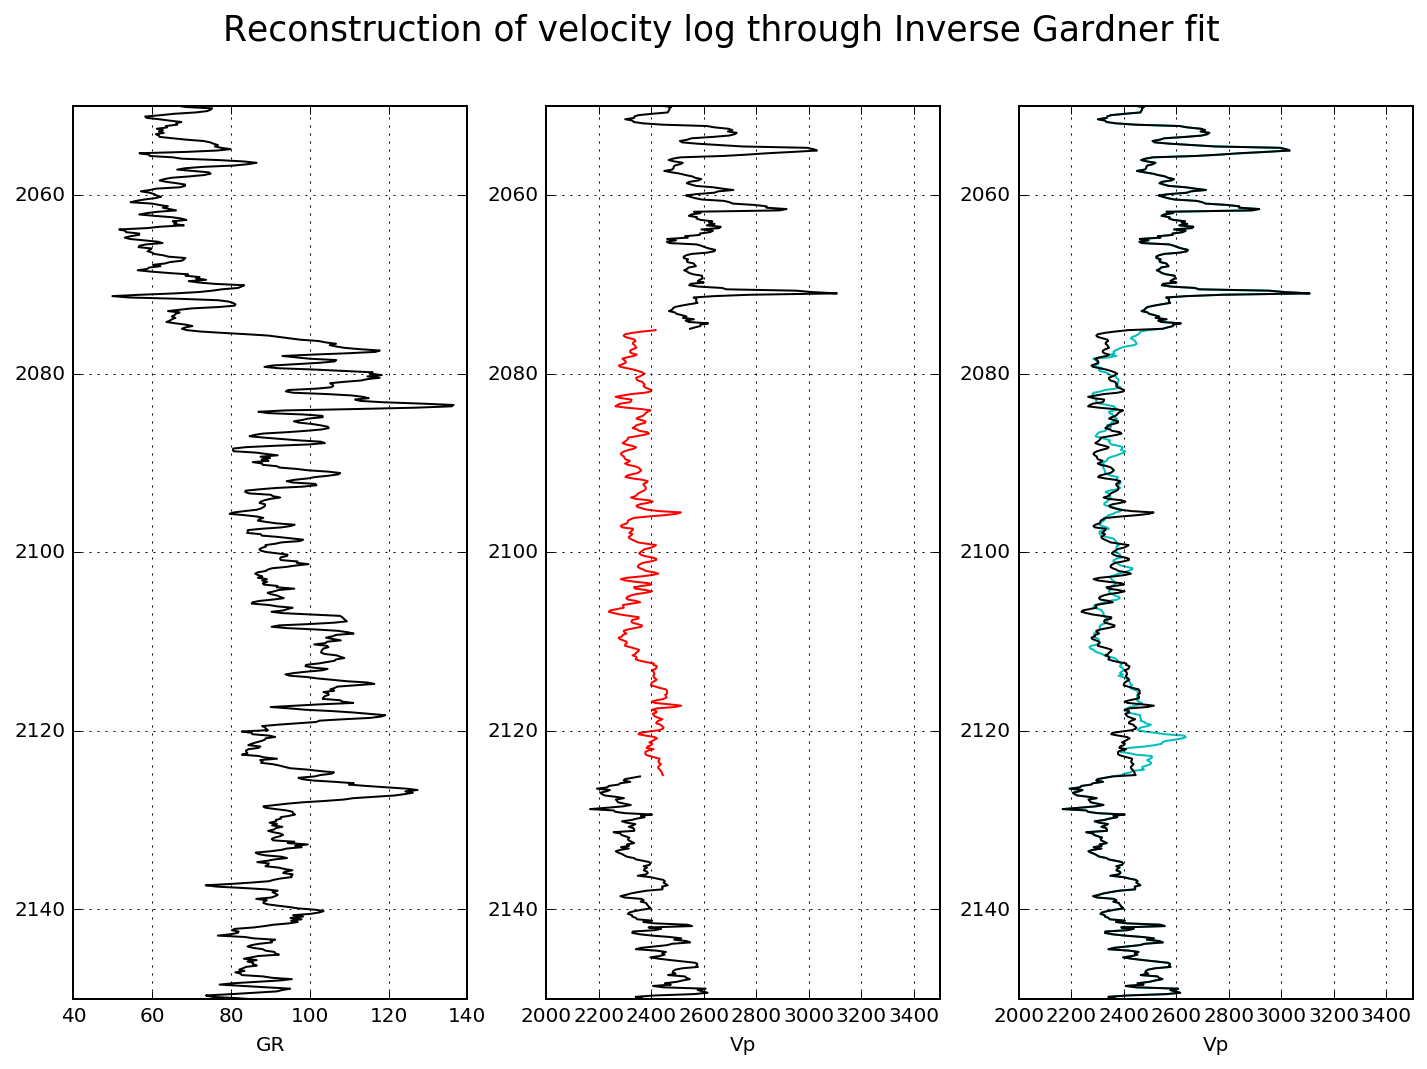

In [13]:
vp_gardner=inv_gardner(rhob, *popt)  # apply inverse Gardner fit to density log to derive Vp
vp_gardner[~hole]=np.nan             # blanks out all the data outside of the 'hole'
vp_rebuilt=vp1.copy()                # creates a copy of the original Vp (with hole)
vp_rebuilt[hole]=vp_gardner[hole]    # fills the hole with vp_gardner

fig,ax = plt.subplots(1,3,figsize=(12,8))
ax[0].plot(gr,z,'-k')
ax[0].set_xlabel('GR')
ax[1].plot(vp1,z,'-k')
ax[1].plot(vp_gardner,z,'-r')
ax[1].set_xlabel('Vp')
ax[1].set_xlim(2000,3500)
ax[2].plot(vpb,z,'-c')
ax[2].plot(vp_rebuilt,z,'-k')
ax[2].set_xlabel('Vp')
ax[2].set_xlim(2000,3500)
for aa in ax:
    aa.set_ylim(2150,2050)
    aa.grid()
plt.suptitle('Reconstruction of velocity log through Inverse Gardner fit', fontsize='xx-large')

In the figure above, I have displayed the velocity log with the missing data together with the reconstructed portion (respectively black and red curves in the middle plot), and also a comparison between the fully-rebuilt velocity log (rightmost plot, black curve) and the original log as it was recorded before digging the "hole" (cyan curve).

### visual reconstruction of least-squares fitting

In the plot below I have used a subset of the synthetic data used before (only 10 points) to illustrate the principle of least-square fitting, the way a brighter friend of mine(\*) has explained it (if you want to go deeper, check the [wikipedia entry](https://en.wikipedia.org/wiki/Least_squares)).

The process of fitting simply involves finding a curve that minimizes the distance between the experimental data (black points) and their projections on the curve. In this case, we are fitting the data with an equation where the known entity is density (and the unknown, which we draw on the Y-axis, is velocity). So we assume that density is correct and for each datapoint we project it along a vertical line onto the curve (dotted black lines in the plot below).

Therefore this particular curve is the one that _overall_ is closer to all the datapoints, i.e. where all these individual segments (the dotted black lines) summed together give a smaller value than any other case (in reality what we're summing is the distances _squared_).

Alright. Maybe you're all better off checking that wikipedia entry, guys.


(\*) Hi, Dario!

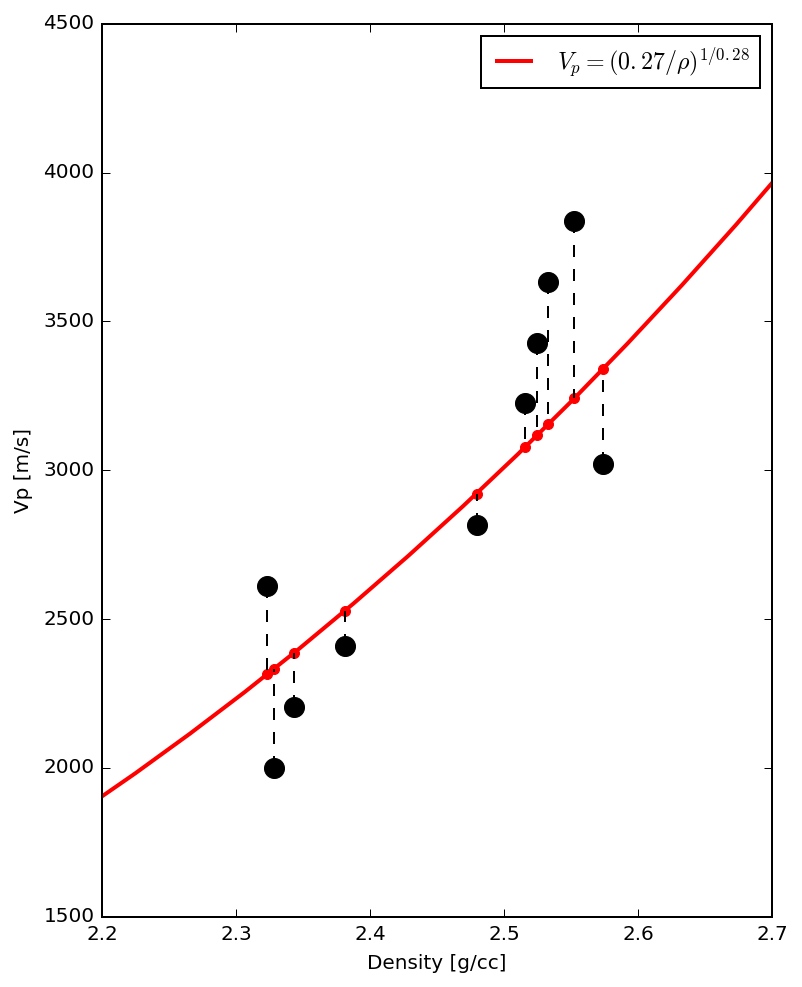

In [23]:
rho_redux=rho_test[::5]
vp_redux=vp_test[::5]

vp_synt_redux=inv_gardner(rho_redux, *popt_synt)

plt.figure(figsize=(6,8))
plt.plot(rho_redux,vp_redux,'ok', ms=10)
plt.plot(rho_synt, vp_synt, '-r', lw=2, label=r'$ V_p = (%.2f / \rho)^{1/%.2f}$' % (popt_synt[0],popt_synt[1]))
plt.plot(rho_redux, vp_synt_redux, '.r', ms=10)

for i in range(rho_redux.size):
    x1,y1=rho_redux[i],vp_redux[i]
    x2,y2=rho_redux[i],vp_synt_redux[i]
    plt.plot([x1,x2],[y1,y2],color='k',ls='--')

plt.xlabel('Density [g/cc]'), plt.xlim(2.2,2.7)
plt.ylabel('Vp [m/s]'), plt.ylim(1500,4500)
plt.legend()